In [1]:
%pip install -r ./requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip freeze | grep -i 'torch'

torch==2.6.0+cpu
torchvision==0.21.0+cpu
Note: you may need to restart the kernel to use updated packages.


# Libraries

In [1]:
import utils
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import albumentations as A
import pickle as pkl
from UNET_model import UNET 


random.seed(42)

/home/yuhaopro/Projects/CV/image-segmentation-cv/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Preparation
In this step, I will be using the `datasets` python library to load both the image and mask together to make it easier for downstream tasks to process the data.
<br>

Once the dataset can be loaded, image augmentation will be performed with the `albumentations` python library to ensure the image size is consistent and our training data is robust.

## Data Loading

In [2]:

class PetDataset(Dataset):
    def __init__(self, image_dir: str, mask_dir: str, transform: A.Compose = None):
        self.image_dir: str = image_dir
        self.mask_dir: str = mask_dir
        self.transform: A.Compose = transform
        self.images = os.listdir(image_dir)

        # print(f"----Initialized Values----")
        # print(f"{self.image_dir} | {self.mask_dir} | {self.transform} | {self.images}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # print(f"index: {index}")
        
        img_path = os.path.join(self.image_dir, self.images[index])
        # print(f"Image path: {img_path}")
        mask_path = os.path.join(self.mask_dir, self.images[index]).replace(".jpg", ".png")
        # print(f"Mask path: {mask_path}")

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        # print(f"Image Type: {type(image)}")
        # print(f"Mask Type: {type(mask)}")

        
        if self.transform is not None:
            # print(f"Shape of image: {image.shape} Shape of mask: {mask.shape}")
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]
            # print(f"New shape of image: {image.shape} New shape of mask: {mask.shape}")


        return image, mask

In [60]:
# def data_to_dict(split_path):
#     images = []
#     masks = []
#     color_dir = os.path.join(split_path, 'color')
#     label_dir = os.path.join(split_path, 'label')
    
#     # Sort to ensure the pairing order is consistent
#     for fname in sorted(os.listdir(color_dir)):
#         image_path = os.path.join(color_dir, fname)
#         mask_fname = fname.replace("jpg", "png")
#         mask_path = os.path.join(label_dir, mask_fname)
        
#         image = np.array(Image.open(image_path).convert(mode="RGB"), dtype=np.uint8)
#         mask = np.array(Image.open(mask_path).convert(mode="L"), dtype=np.float32)
#         images.append(image)
#         masks.append(mask)
        
#     return {"image": images, "mask": masks}


In [61]:
# # features = Features({
# #     "image": Image(mode="RGB"),
# #     "mask": Image(mode="L")
# # })

# train_val_data = data_to_dict("Dataset/TrainVal")
# test_data = data_to_dict("Dataset/Test")

# # train_val_dataset = Dataset.from_dict(train_val_data, features=features)
# # test_dataset = Dataset.from_dict(test_data, features=features)

# train_val_dataset = Dataset.from_dict(train_val_data)
# test_dataset = Dataset.from_dict(test_data)

In [62]:
# # check dataset is properly loaded
# train_val_dataset[0]["mask"]

## Image Augmentations
Based on this [guide](https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/), since the models tend to receive a fixed size tensor, there are a few ways to achieve this.
- Resizing
- Cropping & Padding
<br />

The former way is straight forward but can lead to a loss in image quality, while the latter way is a good balance without compromising the image quality. As part of the first iteration, I will use the resizing augmentation.

In [3]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),               
    A.Rotate(limit=(-40,40)),
    A.ElasticTransform(p=0.5),                   
    A.ColorJitter(p=0.5),
    A.Normalize(), # go before totensor since normalize needs the img as a float  
    A.ToTensorV2(transpose_mask=True),           
], seed=137, strict=True)
 


In [10]:
TRAIN_IMAGE_DIR = "Dataset/TrainVal/color"
TRAIN_MASK_DIR = "Dataset/TrainVal/label"
TEST_IMAGE_DIR = "Dataset/Test/color"
TEST_MASK_DIR = "Dataset/Test/label"

train_val_dataset = PetDataset(image_dir=TRAIN_IMAGE_DIR, mask_dir=TRAIN_MASK_DIR, transform=transform)
test_dataset = PetDataset(image_dir=TEST_IMAGE_DIR, mask_dir=TEST_MASK_DIR)

In [11]:
train_dataloader = DataLoader(train_val_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7754089..2.5354247].


Image batch shape: torch.Size([1, 3, 128, 128])
Mask batch shape: torch.Size([1, 128, 128])
torch.Size([1, 128, 128])


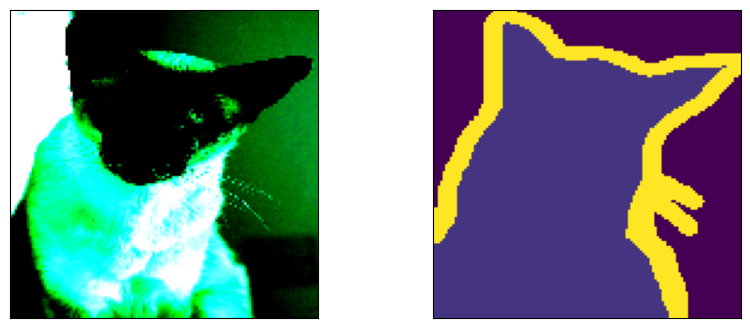

In [20]:

train_image, train_mask = next(iter(train_dataloader))
print(f"Image batch shape: {train_image.size()}")
print(f"Mask batch shape: {train_mask.size()}")

plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
fig = plt.imshow(train_image.squeeze(0).permute(1,2,0))
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

plt.subplot(1,2,2)
print(f"{train_mask.size()}")
fig = plt.imshow(train_mask.permute(1,2,0))
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

In [ ]:
# def get_apply_transform_fn(augmentation):
#     def apply_transform(data):
#         image = np.array(data["image"])
#         mask = np.array(data["mask"])
#         augmented = augmentation(image=image, mask=mask)
#         # print(f"image: {type(augmented['image'])}, mask: {type(augmented['mask'])}")

#         data["image"] = augmented["image"]
#         data["mask"] = augmented["mask"]
#         return data
#     return apply_transform

# aug_transform_fn = get_apply_transform_fn(transform)
# aug_train_val_dataset = train_val_dataset.map(aug_transform_fn)


Map:  27%|██▋       | 996/3680 [00:19<00:16, 159.45 examples/s]/home/yuhaopro/Projects/CV/image-segmentation-cv/.venv/lib/python3.10/site-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
Map: 100%|██████████| 3680/3680 [04:08<00:00, 14.80 examples/s]  


RuntimeError: Could not infer dtype of Image

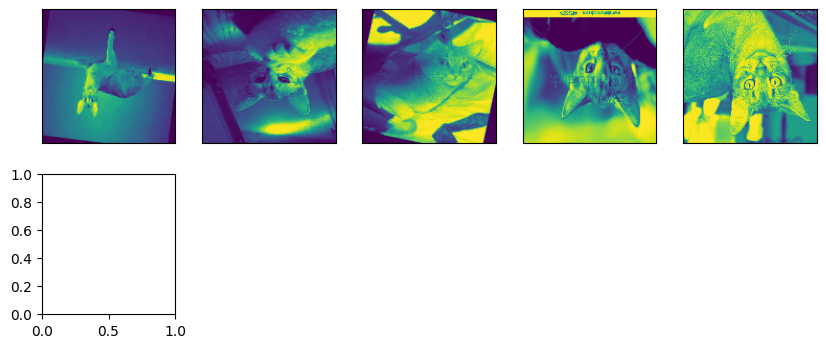

In [ ]:
# # visualize the transform images
# def visualize_transform_images(max, dataset):
#     plt.figure(figsize=(10, 4))
#     for idx in range(max):
#         plt.subplot(2,5,idx+1)
#         # print(dataset[idx])
#         fig = plt.imshow(torch.tensor(dataset[idx]["image"]).numpy()[0])
#         fig.axes.get_xaxis().set_visible(False)
#         fig.axes.get_yaxis().set_visible(False)

#     for idx in range(max):
#         plt.subplot(2,5,idx+1+5)
#         fig = plt.imshow(torch.tensor(dataset[idx]["mask"]).numpy()[0], cmap='gray')
#         fig.axes.get_xaxis().set_visible(False)
#         fig.axes.get_yaxis().set_visible(False)

# visualize_transform_images(5, aug_train_val_dataset)

In [ ]:
# # convert the dataset to tensors
# aug_train_val_dataset.set_format("torch", columns=["image", "mask"])
# test_dataset.set_format("torch", columns=["image", "mask"])
# print(test_dataset[0]["image"])

tensor([[[38, 37, 34,  ..., 30, 30, 30],
         [38, 37, 36,  ..., 31, 30, 30],
         [37, 37, 37,  ..., 31, 30, 30],
         ...,
         [38, 39, 40,  ..., 41, 40, 37],
         [35, 36, 38,  ..., 40, 38, 34],
         [38, 37, 36,  ..., 35, 36, 37]],

        [[36, 35, 32,  ..., 28, 28, 28],
         [36, 35, 34,  ..., 29, 28, 28],
         [35, 35, 35,  ..., 29, 28, 28],
         ...,
         [38, 39, 40,  ..., 40, 39, 36],
         [35, 36, 38,  ..., 39, 37, 33],
         [38, 37, 36,  ..., 33, 34, 35]],

        [[41, 40, 37,  ..., 31, 31, 31],
         [41, 40, 39,  ..., 32, 31, 31],
         [40, 40, 40,  ..., 32, 31, 31],
         ...,
         [46, 47, 48,  ..., 46, 45, 42],
         [43, 44, 46,  ..., 45, 43, 39],
         [46, 45, 44,  ..., 38, 39, 40]]], dtype=torch.uint8)


In [ ]:
# CLIP Model
# from transformers import CLIPProcessor, CLIPModel, CLIPVisionModel
# model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
# vision_model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
# processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


In [ ]:
# image = test_dataset[0]["image"]
# print(image.size)
# inputs = processor(images=image, return_tensors="pt", do_resize=False)
# print(inputs["pixel_values"].shape)
# outputs = vision_model(**inputs)
# print(outputs.last_hidden_state.shape)

# image = test_dataset[0]["image"]
# inputs = processor(images=image, return_tensors="pt", do_resize=False)
# print(inputs["pixel_values"].shape)
# image_features = model.get_image_features(**inputs)
# print(image_features.squeeze(0).shape)

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# def extract_clip_features(data):
#     image = data["image"]
#     inputs = processor(images=image, return_tensors="pt").to(device)
#     with torch.no_grad():
#         features = model.get_image_features(**inputs)
#         features.squeeze(0)
#     data["image"] = features
#     return data

In [ ]:
# convert the pillow images into image features from CLIP
# extracted_aug_train_val_dataset = aug_train_val_dataset.map(extract_clip_features)
# test_dataset = test_dataset.map(extract_clip_features)


In [ ]:
# split the datasets
# split_extracted_aug_train_val_dataset = extracted_aug_train_val_dataset.train_test_split(test_size=0.2)
# train_dataset = split_extracted_aug_train_val_dataset["train"]
# val_dataset = split_extracted_aug_train_val_dataset["test"]

split_aug_train_val_dataset = aug_train_val_dataset.train_test_split(test_size=0.2)
train_dataset = split_aug_train_val_dataset["train"]
val_dataset = split_aug_train_val_dataset["test"]


In [ ]:

# save the dataset into a pickle file to be loaded in
with open("processed_dataset/train.pkl", "wb") as f:
    pkl.dump(train_dataset, f)

with open("processed_dataset/val.pkl", "wb") as f:
    pkl.dump(val_dataset, f)

with open("processed_dataset/test.pkl", "wb") as f:
    pkl.dump(test_dataset, f)

In [ ]:

with open("processed_dataset/train.pkl", "rb") as f:
    train_dataset = pkl.load(f)

with open("processed_dataset/val.pkl", "rb") as f:
    val_dataset = pkl.load(f)

with open("processed_dataset/test.pkl", "rb") as f:
    test_dataset = pkl.load(f)

In [ ]:

DEVICE =  torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, batch in enumerate(loop):
        print(f"Batch {batch_idx}: {batch}")
        images = batch["image"].to(device=DEVICE)
        masks = batch["mask"].float().unsqueeze(1).to(device=DEVICE) # removes the channel on the mask

        print(f"images: {images}")
        print(f"masks: {masks}")

        # forward
        with torch.amp.autocast(): # convolutions are much faster in lower_precision_fp
            predictions = model(images)
            loss = loss_fn(predictions, masks)

        # backward
        optimizer.zero_grad() # in pytorch grad are accumulated, zero it to only account for the current batch of training.
        scaler.scale(loss).backward() # scale the gradients to prevent them from being flushed to 0 due to computational limits
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item()) # additional data to display in the loading bar

In [ ]:

BATCH_SIZE = 2
PIN_MEMORY = False
NUM_WORKERS = 1
LEARNING_RATE = 0.0005
LOAD_MODEL = False
NUM_EPOCHS = 10

model = UNET(in_channels=3, out_channels=1).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loader, val_loader = utils.get_loaders(
    train_dataset,
    val_dataset,
    num_workers=NUM_WORKERS,
    batch_size=BATCH_SIZE,
)

if LOAD_MODEL:
    utils.load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)


utils.check_accuracy(val_loader, model, device=DEVICE)
scaler = torch.amp.GradScaler()

for epoch in range(NUM_EPOCHS):
    train(train_loader, model, optimizer, loss_fn, scaler)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer":optimizer.state_dict(),
    }
    utils.save_checkpoint(checkpoint)

    # check accuracy
    utils.check_accuracy(val_loader, model, device=DEVICE)

    # print some examples to a folder
    utils.save_predictions_as_imgs(
        val_loader, model, folder="saved_images/", device=DEVICE
    )

Checking accuracy...
Batch: {'image': tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0,

RuntimeError: expected scalar type Byte but found Float